# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

env: CUDA_LAUNCH_BLOCKING=1


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_592921/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)


/tmp/ipykernel_592921/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_592921/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)


We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-26 19:12:53,216] A new study created in RDB with name: no-name-3005566b-c859-4ace-9868-b0224aba5d70
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4478342533111572


  0%|          | 2/2000 [00:00<12:20,  2.70it/s]

current_loss: tensor(1.4584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4399303197860718
current_loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:53,  3.74it/s]

current_loss: tensor(1.4345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4188302755355835
current_loss: tensor(1.4345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4318, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:24,  5.19it/s]

current_loss_val:  1.4169422388076782
current_loss: tensor(1.4318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169542789459229
current_loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:14,  6.33it/s]

current_loss_val:  1.4168668985366821
current_loss: tensor(1.4313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164763689041138
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4351, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:05,  6.52it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164206981658936
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4163661003112793


  0%|          | 10/2000 [00:01<04:59,  6.64it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.416327953338623
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.416411280632019
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<04:07,  8.05it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164255857467651
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164351224899292
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<05:57,  5.55it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164456129074097
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4165332317352295
Early Stop at iteration 14 with minimal loss tensor(1.4163, device='cuda:0') and patience 5 and min_delta 1e-07



  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3933, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<13:57,  2.39it/s]

current_loss_val:  1.3766326904296875
current_loss: tensor(1.3933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:59,  3.03it/s]

current_loss_val:  1.311172366142273
current_loss: tensor(1.3424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:41,  3.11it/s]

current_loss: tensor(1.3283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.304735779762268
current_loss: tensor(1.3283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<13:37,  2.44it/s]

current_loss_val:  1.302994728088379
current_loss: tensor(1.3228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<15:51,  2.10it/s]

current_loss_val:  1.298498511314392
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<15:05,  2.20it/s]

current_loss_val:  1.2948365211486816
current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<13:04,  2.54it/s]

current_loss_val:  1.291603684425354
current_loss: tensor(1.3060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<11:38,  2.85it/s]

current_loss_val:  1.285030722618103
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<11:03,  3.00it/s]

current_loss_val:  1.283976435661316
current_loss: tensor(1.2963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<10:02,  3.30it/s]

current_loss_val:  1.2798746824264526
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:34,  3.46it/s]

current_loss_val:  1.2795301675796509
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<07:55,  4.18it/s]

current_loss_val:  1.2794289588928223
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2777893543243408
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<05:56,  5.57it/s]

current_loss_val:  1.2779431343078613
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2773330211639404
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<05:16,  6.26it/s]

current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2757397890090942
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755681276321411
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<04:38,  7.11it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750740051269531
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749508619308472
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<04:22,  7.55it/s]

current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743215560913086
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274085521697998


  1%|          | 22/2000 [00:05<04:19,  7.61it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721960544586182
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<04:11,  7.86it/s]

current_loss_val:  1.2721580266952515
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272037148475647
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<04:06,  8.01it/s]

current_loss_val:  1.2699646949768066
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695608139038086
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<04:04,  8.07it/s]

current_loss_val:  1.2681758403778076
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266435146331787
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<04:02,  8.12it/s]

current_loss_val:  1.2656477689743042
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641202211380005
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:06<04:01,  8.16it/s]

current_loss_val:  1.2643425464630127
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645323276519775
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:06<04:27,  7.36it/s]

current_loss_val:  1.2640575170516968
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26320481300354
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:07<04:13,  7.75it/s]

current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631511688232422
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262601375579834


  2%|▏         | 37/2000 [00:07<04:10,  7.82it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629634141921997
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:07<04:06,  7.97it/s]

current_loss_val:  1.2622989416122437
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618080377578735
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:07<04:02,  8.07it/s]

current_loss_val:  1.262620210647583
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261561393737793
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:08<04:01,  8.10it/s]

current_loss_val:  1.2615318298339844
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620933055877686
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:08<04:00,  8.14it/s]

current_loss_val:  1.2613836526870728
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261634349822998
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:08<03:59,  8.17it/s]

current_loss_val:  1.2619192600250244
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261537790298462
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:08<05:57,  5.46it/s]

current_loss_val:  1.261963963508606
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617459297180176
Early Stop at iteration 48 with minimal loss tensor(1.2614, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:12,473] Trial 0 finished with value: -2.5227670669555664 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.137679483191526, 'penalty_decorrelation_ridge_second_difference': 10.800623030095226}. Best is trial 0 with value: -2.5227670669555664.
  0%|          | 1/2000 [00:00<06:53,  4.83it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26234769821167


  0%|          | 2/2000 [00:00<05:18,  6.27it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622785568237305
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:32,  7.33it/s]

current_loss_val:  1.2622226476669312
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626404762268066
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:17,  7.75it/s]

current_loss_val:  1.2630574703216553
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263257384300232
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:06,  6.50it/s]

current_loss_val:  1.2640043497085571
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264023780822754
Early Stop at iteration 7 with minimal loss tensor(1.2622, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:15,455] Trial 1 finished with value: -2.5244452953338623 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.876078244317295, 'penalty_decorrelation_ridge_second_difference': 23.593645632525796}. Best is trial 0 with value: -2.5227670669555664.
  0%|          | 1/2000 [00:00<05:44,  5.81it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619693279266357
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.35it/s]

current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619173526763916
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616504430770874


  0%|          | 4/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618069648742676
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:15,  7.81it/s]

current_loss_val:  1.2614493370056152
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621533870697021
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:09,  7.99it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618281841278076
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614737749099731
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:07,  8.05it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614638805389404
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612404823303223


  1%|          | 11/2000 [00:01<04:07,  8.04it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612334489822388
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 13/2000 [00:01<04:19,  7.65it/s]

tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607966661453247
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609280347824097


  1%|          | 14/2000 [00:01<04:15,  7.78it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607628107070923
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:13,  7.84it/s]

current_loss_val:  1.2604563236236572
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608219385147095
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:07,  8.00it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601792812347412
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601690292358398


  1%|          | 19/2000 [00:02<04:07,  7.99it/s]

current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606464624404907
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:06,  8.04it/s]

current_loss_val:  1.2600927352905273
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603148221969604
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<04:04,  8.09it/s]

current_loss_val:  1.2604618072509766
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604140043258667
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:04,  8.09it/s]

current_loss_val:  1.2600696086883545
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260311484336853
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:14,  7.76it/s]

current_loss_val:  1.2603904008865356
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260276436805725
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:22,  7.52it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260514497756958
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604697942733765
Early Stop at iteration 28 with minimal loss tensor(1.2601, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:21,314] Trial 2 finished with value: -2.52013897895813 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.678733716264617, 'penalty_decorrelation_ridge_second_difference': 5.97113645379971}. Best is trial 2 with value: -2.52013897895813.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<24:10,  1.38it/s]

current_loss_val:  1.2617732286453247
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<09:49,  3.39it/s]

current_loss_val:  1.2606196403503418
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25814950466156
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:11,  3.26it/s]

current_loss_val:  1.2583482265472412
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<13:57,  2.38it/s]

current_loss_val:  1.2564735412597656
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:37,  3.45it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565288543701172
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565608024597168


  0%|          | 8/2000 [00:02<07:54,  4.19it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563987970352173
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<10:40,  3.11it/s]

current_loss_val:  1.2568049430847168
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<10:24,  3.18it/s]

current_loss_val:  1.2566970586776733
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566996812820435
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:04<11:03,  3.00it/s]

current_loss_val:  1.2571003437042236
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567249536514282
Early Stop at iteration 12 with minimal loss tensor(1.2564, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:27,369] Trial 3 finished with value: -2.5127973556518555 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.560563700708088, 'penalty_decorrelation_ridge_second_difference': 4.839559034868785}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617979049682617
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611395120620728
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:41,  7.10it/s]

current_loss_val:  1.2601346969604492
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594373226165771
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:43,  7.05it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584648132324219
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258373737335205


  0%|          | 7/2000 [00:01<04:31,  7.33it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257995367050171
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:18,  7.70it/s]

current_loss_val:  1.2576477527618408
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582051753997803
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:11,  7.92it/s]

current_loss_val:  1.2578798532485962
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257753849029541
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:57,  6.69it/s]

current_loss_val:  1.2577474117279053
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583550214767456
Early Stop at iteration 12 with minimal loss tensor(1.2576, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:30,968] Trial 4 finished with value: -2.5152955055236816 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.428630267166733, 'penalty_decorrelation_ridge_second_difference': 5.679833952619933}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:45,  4.93it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622202634811401
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:45,  7.00it/s]

current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262125849723816
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620046138763428


  0%|          | 4/2000 [00:00<04:31,  7.34it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623018026351929
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:17,  7.74it/s]

current_loss_val:  1.262444019317627
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625694274902344
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:06,  6.51it/s]

current_loss_val:  1.2629708051681519
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630164623260498
Early Stop at iteration 7 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:33,813] Trial 5 finished with value: -2.5240092277526855 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.657404631359025, 'penalty_decorrelation_ridge_second_difference': 21.372553939901092}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:40,  5.00it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623984813690186
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:47,  6.96it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262347936630249
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623155117034912


  0%|          | 4/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627837657928467
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:17,  7.75it/s]

current_loss_val:  1.263396143913269
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635793685913086
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:10,  6.41it/s]

current_loss_val:  1.2640575170516968
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643768787384033
Early Stop at iteration 7 with minimal loss tensor(1.2623, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:36,854] Trial 6 finished with value: -2.5246307849884033 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.708843125943726, 'penalty_decorrelation_ridge_second_difference': 24.607486784354045}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:47,  4.91it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262135624885559
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:48,  6.92it/s]

current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620701789855957
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262006402015686


  0%|          | 4/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622952461242676
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:19,  7.69it/s]

current_loss_val:  1.2623367309570312
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627651691436768
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:20,  6.22it/s]

current_loss_val:  1.262795090675354
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262534260749817
Early Stop at iteration 7 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:40,348] Trial 7 finished with value: -2.524013042449951 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.470702246613705, 'penalty_decorrelation_ridge_second_difference': 12.713327772427405}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<05:35,  5.96it/s]

current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261792778968811
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605217695236206
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:43,  7.04it/s]

current_loss_val:  1.2599376440048218
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591416835784912
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257526159286499
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25783109664917


  0%|          | 7/2000 [00:00<04:17,  7.73it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577930688858032
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:12,  7.87it/s]

current_loss_val:  1.2577781677246094
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576019763946533
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 9/2000 [00:01<04:57,  6.69it/s]


tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258007287979126
Early Stop at iteration 9 with minimal loss tensor(1.2575, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:13:44,389] Trial 8 finished with value: -2.515052556991577 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.754316694656138, 'penalty_decorrelation_ridge_second_difference': 6.954455081567298}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:49,  4.89it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621620893478394
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:19,  6.26it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620681524276733
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:50,  4.86it/s]

current_loss_val:  1.261942744255066
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262220859527588
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<05:19,  6.24it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622801065444946
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262323021888733


  0%|          | 7/2000 [00:01<04:56,  6.72it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626938819885254
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:18,  5.27it/s]


current_loss_val:  1.262589931488037
Early Stop at iteration 7 with minimal loss tensor(1.2619, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:13:47,963] Trial 9 finished with value: -2.5238852500915527 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.64309078734584, 'penalty_decorrelation_ridge_second_difference': 18.280498624000536}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:40,  5.00it/s]

current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619022130966187
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:45,  6.99it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261842131614685
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261340618133545


  0%|          | 4/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615163326263428
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260917067527771
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610825300216675


  0%|          | 7/2000 [00:00<04:29,  7.39it/s]

current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610752582550049
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:18,  7.72it/s]

current_loss_val:  1.2612278461456299
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260327935218811
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:12,  7.89it/s]

current_loss_val:  1.2606401443481445
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607697248458862
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:08,  7.99it/s]

current_loss_val:  1.2607964277267456
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26063072681427
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:45,  6.96it/s]


current_loss_val:  1.2607749700546265
Early Stop at iteration 13 with minimal loss tensor(1.2603, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:13:51,730] Trial 10 finished with value: -2.520655870437622 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.860627598083482, 'penalty_decorrelation_ridge_second_difference': 2.1838082540176322}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<05:34,  5.98it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621346712112427
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:28,  7.45it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620720863342285
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620165348052979


  0%|          | 4/2000 [00:00<04:19,  7.68it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262313961982727
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:13,  7.86it/s]

current_loss_val:  1.2623730897903442
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628262042999268
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:56,  6.73it/s]

current_loss_val:  1.262843132019043
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624719142913818
Early Stop at iteration 7 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:13:54,766] Trial 11 finished with value: -2.5240328311920166 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.70083179230288, 'penalty_decorrelation_ridge_second_difference': 12.23664755327017}. Best is trial 3 with value: -2.5127973556518555.
  0%|          | 1/2000 [00:00<06:36,  5.04it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617822885513306
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:24,  5.19it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606841325759888
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:56,  6.74it/s]

current_loss_val:  1.2584092617034912
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571619749069214
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:42,  7.05it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563285827636719
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:41,  7.08it/s]

current_loss_val:  1.2565466165542603
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566828727722168
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:29,  7.38it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256570816040039
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562183141708374


  0%|          | 10/2000 [00:01<04:24,  7.52it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256536602973938
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:17,  7.73it/s]

current_loss_val:  1.2566229104995728
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256473183631897
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:12,  7.86it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564470767974854
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:24,  7.50it/s]

current_loss_val:  1.256104826927185
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563496828079224
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:16,  7.74it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561575174331665
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561120986938477


  1%|          | 18/2000 [00:02<04:15,  7.75it/s]

current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565113306045532
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:14,  7.78it/s]

current_loss_val:  1.255879282951355
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559608221054077
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:09,  7.92it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560324668884277
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558362483978271


  1%|          | 23/2000 [00:03<04:08,  7.95it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558882236480713
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:08,  7.94it/s]

current_loss_val:  1.2557761669158936
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255652666091919
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:08,  7.94it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553017139434814
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:26,  7.40it/s]

current_loss_val:  1.255318522453308
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549114227294922
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:17,  7.65it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25373375415802
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253367304801941


  2%|▏         | 31/2000 [00:04<04:14,  7.74it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536945343017578
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:11,  7.83it/s]

current_loss_val:  1.2533329725265503
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532209157943726
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:08,  7.92it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532297372817993
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539150714874268


  2%|▏         | 36/2000 [00:04<04:07,  7.94it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535068988800049
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<04:27,  7.34it/s]

current_loss_val:  1.2534528970718384
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534664869308472
Early Stop at iteration 37 with minimal loss tensor(1.2532, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:14:01,969] Trial 12 finished with value: -2.506441593170166 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.2211065295631602, 'penalty_decorrelation_ridge_second_difference': 10.06250211392788}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619050741195679
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618467807769775
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613615989685059


  0%|          | 4/2000 [00:00<04:24,  7.54it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616075277328491
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:37,  7.19it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610362768173218
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612195014953613


  0%|          | 7/2000 [00:00<04:27,  7.44it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612251043319702
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:18,  7.70it/s]

current_loss_val:  1.261775016784668
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606050968170166
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:13,  7.84it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607593536376953
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609461545944214


  1%|          | 12/2000 [00:01<04:10,  7.94it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260788917541504
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:42,  7.03it/s]

current_loss_val:  1.2608904838562012
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260857343673706
Early Stop at iteration 13 with minimal loss tensor(1.2606, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:14:05,662] Trial 13 finished with value: -2.521210193634033 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.429152054946364, 'penalty_decorrelation_ridge_second_difference': 1.2803063852385823}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:42,  4.96it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623533010482788
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:51,  6.85it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622801065444946
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26223623752594


  0%|          | 4/2000 [00:00<04:35,  7.24it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626768350601196
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:36,  7.21it/s]

current_loss_val:  1.2630656957626343
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632925510406494
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:23,  6.17it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264044165611267
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640578746795654
Early Stop at iteration 7 with minimal loss tensor(1.2622, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:14:08,956] Trial 14 finished with value: -2.52447247505188 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.0765466408623, 'penalty_decorrelation_ridge_second_difference': 22.941989303082956}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619190216064453
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26173734664917
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26089608669281


  0%|          | 4/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604727745056152
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:19,  7.68it/s]

current_loss_val:  1.260247826576233
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588597536087036
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:14,  7.83it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578504085540771
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574690580368042


  0%|          | 9/2000 [00:01<04:13,  7.86it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573306560516357
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:12,  7.88it/s]

current_loss_val:  1.2567850351333618
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568414211273193
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:11,  7.90it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568522691726685
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565090656280518


  1%|          | 14/2000 [00:01<04:36,  7.17it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565999031066895
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:38,  7.14it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256652593612671
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568395137786865


  1%|          | 17/2000 [00:02<04:31,  7.31it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569856643676758
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:41,  7.05it/s]


current_loss_val:  1.2570254802703857
Early Stop at iteration 17 with minimal loss tensor(1.2565, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:13,572] Trial 15 finished with value: -2.5130178928375244 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.759466196213432, 'penalty_decorrelation_ridge_second_difference': 27.07142750171647}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:43,  4.96it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26180100440979
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:10,  5.39it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599424123764038
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:28,  4.46it/s]

current_loss_val:  1.2583249807357788
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<12:24,  2.68it/s]

current_loss_val:  1.2568310499191284
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:37,  3.86it/s]

current_loss_val:  1.2561185359954834
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561172246932983
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:12,  5.34it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255503535270691
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255496859550476


  0%|          | 9/2000 [00:02<05:36,  5.91it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552392482757568
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<04:52,  6.79it/s]

current_loss_val:  1.2553616762161255
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550451755523682
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:30,  7.36it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551518678665161
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550835609436035


  1%|          | 14/2000 [00:02<04:28,  7.41it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545300722122192
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:20,  7.63it/s]

current_loss_val:  1.2547590732574463
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549011707305908
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<04:14,  7.80it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547818422317505
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550954818725586


  1%|          | 18/2000 [00:03<06:01,  5.48it/s]


current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551932334899902
Early Stop at iteration 18 with minimal loss tensor(1.2545, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:18,975] Trial 16 finished with value: -2.5090601444244385 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.758396699855358, 'penalty_decorrelation_ridge_second_difference': 13.83701795719336}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:45,  4.93it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261826753616333
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:49,  6.91it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616521120071411
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599364519119263


  0%|          | 4/2000 [00:00<04:38,  7.16it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587226629257202
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:48,  6.91it/s]

current_loss_val:  1.2581546306610107
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574636936187744
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:29,  7.39it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568132877349854
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568244934082031


  0%|          | 9/2000 [00:01<04:24,  7.53it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563761472702026
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:36,  7.19it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562742233276367
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562390565872192


  1%|          | 12/2000 [00:01<04:28,  7.39it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558863162994385
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:24,  7.51it/s]

current_loss_val:  1.2561060190200806
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561756372451782
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:16,  7.74it/s]

current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559021711349487
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256187081336975


  1%|          | 16/2000 [00:02<04:48,  6.87it/s]


current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562583684921265
Early Stop at iteration 16 with minimal loss tensor(1.2559, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:23,482] Trial 17 finished with value: -2.511772394180298 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.210457489773857, 'penalty_decorrelation_ridge_second_difference': 15.72964541949246}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:57,  4.78it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618253231048584


  0%|          | 2/2000 [00:00<05:24,  6.17it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615944147109985
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:45,  7.00it/s]

current_loss_val:  1.2588934898376465
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571463584899902
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256900668144226
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567729949951172


  0%|          | 7/2000 [00:00<04:24,  7.54it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256644368171692
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:37,  7.17it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564057111740112
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562485933303833


  0%|          | 10/2000 [00:01<04:30,  7.37it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557642459869385
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:21,  7.61it/s]

current_loss_val:  1.255425214767456
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554436922073364
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:16,  7.74it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554682493209839
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554947137832642


  1%|          | 15/2000 [00:02<04:41,  7.05it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255494475364685
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:54,  6.73it/s]


current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255496859550476
Early Stop at iteration 15 with minimal loss tensor(1.2554, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:27,900] Trial 18 finished with value: -2.510850667953491 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.013054132308291666, 'penalty_decorrelation_ridge_second_difference': 17.70629146332012}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619526386260986
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618155479431152
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261264443397522


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610009908676147
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:20,  7.65it/s]

current_loss_val:  1.2604926824569702
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597310543060303
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:15,  7.79it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594510316848755
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591142654418945


  0%|          | 9/2000 [00:01<04:14,  7.81it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259040355682373
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:15,  7.78it/s]

current_loss_val:  1.2590843439102173
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592971324920654
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:12,  7.88it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591570615768433
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591290473937988


  1%|          | 13/2000 [00:01<04:38,  7.12it/s]


current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591320276260376
Early Stop at iteration 13 with minimal loss tensor(1.2590, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:31,964] Trial 19 finished with value: -2.518080472946167 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.910011237277534, 'penalty_decorrelation_ridge_second_difference': 20.59973061823117}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:52,  4.85it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618300914764404
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:52,  6.82it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616769075393677
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602415084838867


  0%|          | 4/2000 [00:00<04:37,  7.19it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592518329620361
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:50,  6.87it/s]

current_loss_val:  1.2586731910705566
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578860521316528
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:30,  7.37it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257007360458374
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257153868675232


  0%|          | 9/2000 [00:01<04:24,  7.52it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571128606796265
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:20,  7.63it/s]

current_loss_val:  1.2565962076187134
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568515539169312
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:15,  7.76it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569127082824707
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566449642181396


  1%|          | 14/2000 [00:01<04:41,  7.06it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569940090179443
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:58,  6.66it/s]


current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256983995437622
Early Stop at iteration 14 with minimal loss tensor(1.2566, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:36,077] Trial 20 finished with value: -2.513192653656006 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.5593744956338345, 'penalty_decorrelation_ridge_second_difference': 14.359586852396404}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617907524108887
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:43,  5.82it/s]

current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592536211013794
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:21,  6.20it/s]

current_loss_val:  1.2570469379425049
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571533918380737


  0%|          | 5/2000 [00:00<04:56,  6.72it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557518482208252
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:33,  7.28it/s]

current_loss_val:  1.2556298971176147
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255902647972107
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:21,  7.61it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548397779464722
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550349235534668


  0%|          | 10/2000 [00:01<04:18,  7.69it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551734447479248
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:16,  7.75it/s]

current_loss_val:  1.2550677061080933
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553565502166748
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:55,  6.72it/s]


current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553335428237915
Early Stop at iteration 12 with minimal loss tensor(1.2548, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:39,555] Trial 21 finished with value: -2.5096793174743652 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.07953499380168738, 'penalty_decorrelation_ridge_second_difference': 6.2979628794286455}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617844343185425
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594366073608398
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:46,  6.97it/s]

current_loss_val:  1.2573572397232056
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257253646850586
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:26,  7.47it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255494475364685
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557753324508667


  0%|          | 7/2000 [00:00<04:24,  7.54it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255926251411438
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:21,  7.61it/s]

current_loss_val:  1.2558529376983643
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555010318756104
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:02,  6.59it/s]


current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557244300842285
Early Stop at iteration 9 with minimal loss tensor(1.2555, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:42,964] Trial 22 finished with value: -2.510988712310791 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6526993490497958, 'penalty_decorrelation_ridge_second_difference': 7.926070068642405}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:22,  5.22it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617793083190918
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:06,  5.46it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259906530380249
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:57,  6.71it/s]

current_loss_val:  1.2585232257843018
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582643032073975
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:31,  7.34it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570762634277344
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256898283958435


  0%|          | 7/2000 [00:01<04:28,  7.41it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256735920906067
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:22,  7.57it/s]

current_loss_val:  1.2574928998947144
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568362951278687
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:17,  7.74it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256814956665039
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573933601379395


  1%|          | 11/2000 [00:01<04:59,  6.64it/s]


current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569876909255981
Early Stop at iteration 11 with minimal loss tensor(1.2567, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:46,918] Trial 23 finished with value: -2.5134716033935547 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.726863863600887, 'penalty_decorrelation_ridge_second_difference': 0.6880423245697251}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617948055267334
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:43,  5.82it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605383396148682
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:50,  6.87it/s]

current_loss_val:  1.257892370223999
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564289569854736
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256074070930481
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563616037368774


  0%|          | 7/2000 [00:00<04:23,  7.56it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563278675079346
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561426162719727


  0%|          | 8/2000 [00:01<07:06,  4.68it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<10:26,  3.18it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256271243095398
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:31,  4.41it/s]


current_loss_val:  1.256170630455017
Early Stop at iteration 9 with minimal loss tensor(1.2561, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:50,709] Trial 24 finished with value: -2.5121476650238037 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.31840484329364993, 'penalty_decorrelation_ridge_second_difference': 12.475116990078005}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:34,  5.97it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261794090270996
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:39,  5.88it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603055238723755
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:19,  6.24it/s]

current_loss_val:  1.2571170330047607
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571284770965576


  0%|          | 5/2000 [00:00<04:53,  6.80it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560322284698486
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:35,  7.23it/s]

current_loss_val:  1.2555266618728638
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556791305541992
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:25,  7.51it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550369501113892
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552708387374878


  0%|          | 10/2000 [00:01<04:21,  7.62it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255368709564209
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:18,  7.70it/s]

current_loss_val:  1.2554190158843994
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<05:10,  6.40it/s]

current_loss_val:  1.2551872730255127
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553139925003052
Early Stop at iteration 12 with minimal loss tensor(1.2550, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:14:54,444] Trial 25 finished with value: -2.51007342338562 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1671363007121158, 'penalty_decorrelation_ridge_second_difference': 3.804582020674792}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:36,  5.95it/s]

current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618885040283203
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.29it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617753744125366
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261042594909668


  0%|          | 4/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26058828830719
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:23,  7.58it/s]

current_loss_val:  1.2600234746932983
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595518827438354
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:18,  7.72it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583645582199097
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588000297546387


  0%|          | 9/2000 [00:01<04:16,  7.75it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589478492736816
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:43,  7.02it/s]

current_loss_val:  1.259090542793274
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591992616653442


  1%|          | 11/2000 [00:01<04:53,  6.78it/s]


current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592337131500244
Early Stop at iteration 11 with minimal loss tensor(1.2584, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:14:58,215] Trial 26 finished with value: -2.5167291164398193 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.215630277045246, 'penalty_decorrelation_ridge_second_difference': 13.740840336560797}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617827653884888
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:44,  5.81it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608325481414795
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:48,  6.93it/s]

current_loss_val:  1.2590522766113281
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577534914016724
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568352222442627
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570242881774902


  0%|          | 7/2000 [00:01<04:44,  7.01it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571072578430176
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:40,  7.10it/s]

current_loss_val:  1.2567628622055054
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568005323410034
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:28,  7.42it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565927505493164
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570253610610962


  1%|          | 12/2000 [00:01<04:20,  7.62it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567490339279175
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:22,  7.58it/s]

current_loss_val:  1.2564873695373535
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256441354751587
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:17,  7.71it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567061185836792
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563973665237427


  1%|          | 17/2000 [00:02<04:29,  7.35it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25635826587677
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:31,  7.29it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564812898635864
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563979625701904


  1%|          | 20/2000 [00:02<04:26,  7.43it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566958665847778
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:22,  7.53it/s]

current_loss_val:  1.2559036016464233
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560091018676758
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:18,  7.65it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561043500900269


  1%|          | 24/2000 [00:03<06:20,  5.20it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559664249420166
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<05:18,  6.19it/s]

current_loss_val:  1.2557605504989624
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556484937667847
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:44,  6.93it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557575702667236
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557398080825806


  1%|▏         | 29/2000 [00:04<04:34,  7.18it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555830478668213
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:24,  7.44it/s]

current_loss_val:  1.255558729171753
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552366256713867
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:18,  7.62it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550679445266724
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254403829574585


  2%|▏         | 34/2000 [00:04<04:15,  7.68it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545911073684692
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<04:16,  7.67it/s]

current_loss_val:  1.254611849784851
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542686462402344
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:14,  7.71it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545238733291626
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254543662071228


  2%|▏         | 39/2000 [00:05<04:13,  7.73it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544487714767456
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:37,  7.05it/s]

current_loss_val:  1.2551054954528809
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548340559005737
Early Stop at iteration 40 with minimal loss tensor(1.2543, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 19:15:05,577] Trial 27 finished with value: -2.5085370540618896 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.7192528043252, 'penalty_decorrelation_ridge_second_difference': 9.450911142583106}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<06:45,  4.93it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618683576583862
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:52,  6.83it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616760730743408
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603538036346436


  0%|          | 4/2000 [00:00<04:37,  7.18it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593835592269897
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:27,  7.45it/s]

current_loss_val:  1.2576887607574463
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572575807571411
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:20,  7.64it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25679349899292
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565220594406128


  0%|          | 9/2000 [00:01<04:15,  7.79it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563930749893188
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:21,  7.61it/s]

current_loss_val:  1.2563272714614868
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561571598052979
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:15,  7.77it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560912370681763
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:34,  7.24it/s]

current_loss_val:  1.2560315132141113
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560533285140991
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:26,  7.45it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560949325561523
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561582326889038


  1%|          | 17/2000 [00:02<04:48,  6.87it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561734914779663
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:50,  6.84it/s]


current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562180757522583
Early Stop at iteration 17 with minimal loss tensor(1.2560, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:15:09,676] Trial 28 finished with value: -2.5120630264282227 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8551719430976, 'penalty_decorrelation_ridge_second_difference': 21.209991740465657}. Best is trial 12 with value: -2.506441593170166.
  0%|          | 1/2000 [00:00<05:52,  5.68it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618452310562134
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:39,  7.15it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617136240005493
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260607123374939


  0%|          | 4/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598680257797241
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:24,  7.53it/s]

current_loss_val:  1.259280800819397
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258492350578308
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:52,  6.81it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257839322090149
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:38,  7.15it/s]

current_loss_val:  1.2578145265579224
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575098276138306
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:57,  6.68it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577323913574219
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:36,  7.18it/s]

current_loss_val:  1.2576721906661987
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575936317443848
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:17,  6.26it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579209804534912
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<05:10,  6.40it/s]


current_loss_val:  1.257881999015808
Early Stop at iteration 13 with minimal loss tensor(1.2575, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 19:15:13,561] Trial 29 finished with value: -2.515019416809082 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.267260597696197, 'penalty_decorrelation_ridge_second_difference': 13.359065031991106}. Best is trial 12 with value: -2.506441593170166.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:56, 17.74it/s]

current_loss: tensor(1.4622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4318, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<00:48, 20.37it/s]

current_loss: tensor(1.4318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:48, 20.25it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:50, 19.37it/s]

current_loss: tensor(1.4306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:48, 20.43it/s]

current_loss: tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<00:50, 19.44it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:47, 20.42it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:48, 20.03it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:01<00:49, 19.29it/s]

current_loss: tensor(1.4303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:02<00:53, 17.90it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:02<00:50, 19.05it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 49/1000 [00:02<00:47, 19.99it/s]

tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:02<00:45, 20.60it/s]

current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:02<00:44, 21.25it/s]

current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:03<00:44, 21.25it/s]

current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:03<00:46, 20.07it/s]

current_loss: tensor(1.4293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:03<00:44, 20.84it/s]

current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:03<00:45, 20.17it/s]

current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:03<00:45, 20.11it/s]

current_loss: tensor(1.4290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:04<00:43, 20.92it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:04<00:42, 21.37it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:04<00:41, 21.88it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:04<00:42, 21.41it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:05<00:41, 21.85it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 106/1000 [00:05<00:54, 16.47it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 108/1000 [00:05<01:21, 10.95it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 110/1000 [00:06<01:44,  8.55it/s]

current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:06<00:51, 17.39it/s]


current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 110 with minimal loss tensor(1.4288, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<02:09,  7.70it/s]

current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3757297992706299
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3301, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<02:06,  7.92it/s]

current_loss_val:  1.306331753730774


  0%|          | 3/1000 [00:00<02:24,  6.91it/s]

current_loss: tensor(1.3301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3008091449737549
current_loss: tensor(1.3119, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<02:10,  7.64it/s]

current_loss: tensor(1.3062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2995814085006714
current_loss: tensor(1.3062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2966773509979248
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<02:04,  7.95it/s]

current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2906358242034912
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2877105474472046
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:02,  8.11it/s]

current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866672277450562
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2824270725250244
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<02:01,  8.13it/s]

current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2764605283737183
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273210048675537
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<02:00,  8.16it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709470987319946
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683645486831665
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<02:00,  8.20it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682229280471802
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683885097503662
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:02<02:10,  7.56it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679941654205322
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:02<02:04,  7.87it/s]

current_loss_val:  1.2689580917358398
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268343448638916
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:02<02:02,  7.99it/s]

current_loss_val:  1.2677452564239502
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675033807754517
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<02:00,  8.09it/s]

current_loss_val:  1.2665818929672241
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672781944274902
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:03<01:59,  8.15it/s]

current_loss_val:  1.2669684886932373
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653782367706299
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:03<01:59,  8.17it/s]

current_loss_val:  1.2644258737564087
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621885538101196
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:03<02:11,  7.42it/s]

current_loss_val:  1.2623465061187744
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627769708633423


  3%|▎         | 29/1000 [00:03<02:41,  6.03it/s]

current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627196311950684
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:04<03:49,  4.23it/s]

current_loss_val:  1.261423945426941
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 31/1000 [00:04<04:07,  3.92it/s]

tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613147497177124
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:04<04:07,  3.92it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610852718353271
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:05<04:38,  3.48it/s]

current_loss_val:  1.2601892948150635
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:05<03:52,  4.15it/s]

current_loss_val:  1.2606892585754395
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601157426834106
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:05<04:40,  3.44it/s]

current_loss_val:  1.2599424123764038
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:06<05:45,  2.79it/s]

current_loss_val:  1.2600032091140747
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:07<08:33,  1.87it/s]

current_loss_val:  1.2603086233139038
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:08<09:28,  1.69it/s]

current_loss_val:  1.2602393627166748
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:08<09:05,  1.76it/s]

current_loss_val:  1.2600572109222412
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:08<08:05,  1.98it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259774923324585
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:09<07:42,  2.07it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259824514389038
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:09<07:09,  2.23it/s]

current_loss_val:  1.2596222162246704
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:10<07:21,  2.17it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258390188217163
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:10<06:37,  2.40it/s]

current_loss_val:  1.2582570314407349
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 46/1000 [00:11<06:41,  2.37it/s]

tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581772804260254
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:11<06:44,  2.35it/s]

current_loss_val:  1.256937026977539
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:11<06:31,  2.43it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575033903121948
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:12<06:32,  2.42it/s]

current_loss_val:  1.2569133043289185
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:12<06:12,  2.55it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566401958465576
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:12<04:22,  3.61it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562261819839478
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557858228683472


  5%|▌         | 53/1000 [00:13<03:38,  4.33it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547516822814941
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:13<02:45,  5.69it/s]

current_loss_val:  1.2547441720962524
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546210289001465
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:13<02:32,  6.19it/s]

current_loss_val:  1.2544519901275635
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254905104637146
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:13<02:12,  7.08it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254870891571045
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549666166305542
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:13<02:07,  7.37it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550787925720215
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:14<03:41,  4.25it/s]

current_loss_val:  1.254626750946045
Early Stop at iteration 60 with minimal loss tensor(1.2545, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [10]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:21<54:33,  4.12s/it]  

[convergence] ELBO/obs=-6.750324  smoothed=-6.712258  tol=0.001

Iteration [5/800] train=6.7503  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0543 σmin=0.0517 σmax=0.0584  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049363  τ₁≈1.6493  τ₂≈3.1719  |  (EB targets) τ₄*≈0.38466  τ₁*≈85.846  τ₂*≈137.36
E_qf_total≈37.1928  E_qf1≈0.3118  E_qf2≈0.2636
[monitor] τ₄·E_qf≈1.84  target≈14.31 | τ₁·E_qf1≈0.51  target≈26.77 | τ₂·E_qf2≈0.84  target≈36.21
 [ELBO] per-obs=-6.750324


  1%|▏         | 10/800 [00:41<51:54,  3.94s/it]

[convergence] ELBO/obs=-7.129899  smoothed=-6.846479  tol=0.001

Iteration [10/800] train=7.1299  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0591 σmin=0.0536 σmax=0.0719  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031209  τ₁≈1.324  τ₂≈2.337  |  (EB targets) τ₄*≈0.38572  τ₁*≈82.761  τ₂*≈138.36
E_qf_total≈37.0365  E_qf1≈0.3483  E_qf2≈0.2593
[monitor] τ₄·E_qf≈1.16  target≈14.29 | τ₁·E_qf1≈0.46  target≈28.83 | τ₂·E_qf2≈0.61  target≈35.88
 [ELBO] per-obs=-7.129899


  2%|▏         | 15/800 [01:01<53:45,  4.11s/it]

[convergence] ELBO/obs=-7.452133  smoothed=-7.044154  tol=0.001

Iteration [15/800] train=7.4521  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0640 σmin=0.0553 σmax=0.1100  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.02246  τ₁≈1.2253  τ₂≈2.0615  |  (EB targets) τ₄*≈0.38595  τ₁*≈80.691  τ₂*≈139.26
E_qf_total≈37.0021  E_qf1≈0.3743  E_qf2≈0.2555
[monitor] τ₄·E_qf≈0.83  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.21 | τ₂·E_qf2≈0.53  target≈35.58
 [ELBO] per-obs=-7.452133


  2%|▎         | 20/800 [01:21<51:33,  3.97s/it]

[convergence] ELBO/obs=-7.984242  smoothed=-7.344373  tol=0.001

Iteration [20/800] train=7.9842  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0666 σmin=0.0562 σmax=0.1293  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019261  τ₁≈1.2069  τ₂≈2.0071  |  (EB targets) τ₄*≈0.38579  τ₁*≈80.166  τ₂*≈140.19
E_qf_total≈37.0259  E_qf1≈0.3812  E_qf2≈0.2516
[monitor] τ₄·E_qf≈0.71  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.56 | τ₂·E_qf2≈0.50  target≈35.27
 [ELBO] per-obs=-7.984242


  3%|▎         | 25/800 [01:41<50:43,  3.93s/it]

[convergence] ELBO/obs=-8.297612  smoothed=-7.694603  tol=0.001

Iteration [25/800] train=8.2976  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0694 σmin=0.0572 σmax=0.1512  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.016181  τ₁≈1.1862  τ₂≈1.976  |  (EB targets) τ₄*≈0.38549  τ₁*≈79.223  τ₂*≈139.28
E_qf_total≈37.0697  E_qf1≈0.3936  E_qf2≈0.2554
[monitor] τ₄·E_qf≈0.60  target≈14.29 | τ₁·E_qf1≈0.47  target≈31.18 | τ₂·E_qf2≈0.50  target≈35.57
 [ELBO] per-obs=-8.297612


  4%|▍         | 30/800 [02:00<50:23,  3.93s/it]

[convergence] ELBO/obs=-8.780941  smoothed=-8.076605  tol=0.001

Iteration [30/800] train=8.7809  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0712 σmin=0.0578 σmax=0.1653  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.014569  τ₁≈1.1798  τ₂≈1.968  |  (EB targets) τ₄*≈0.38524  τ₁*≈79.204  τ₂*≈140.55
E_qf_total≈37.1073  E_qf1≈0.3939  E_qf2≈0.2501
[monitor] τ₄·E_qf≈0.54  target≈14.30 | τ₁·E_qf1≈0.46  target≈31.20 | τ₂·E_qf2≈0.49  target≈35.15
 [ELBO] per-obs=-8.780941


  4%|▍         | 35/800 [02:20<50:01,  3.92s/it]

[convergence] ELBO/obs=-8.798975  smoothed=-8.407520  tol=0.001

Iteration [35/800] train=8.7990  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0728 σmin=0.0583 σmax=0.1767  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013218  τ₁≈1.1789  τ₂≈1.9664  |  (EB targets) τ₄*≈0.38494  τ₁*≈79.174  τ₂*≈140.76
E_qf_total≈37.1521  E_qf1≈0.3943  E_qf2≈0.2492
[monitor] τ₄·E_qf≈0.49  target≈14.30 | τ₁·E_qf1≈0.46  target≈31.22 | τ₂·E_qf2≈0.49  target≈35.08
 [ELBO] per-obs=-8.798975


  5%|▌         | 40/800 [02:39<49:43,  3.93s/it]

[convergence] ELBO/obs=-8.774540  smoothed=-8.567025  tol=0.001

Iteration [40/800] train=8.7745  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0741 σmin=0.0587 σmax=0.1874  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.012102  τ₁≈1.1736  τ₂≈1.9684  |  (EB targets) τ₄*≈0.38467  τ₁*≈78.417  τ₂*≈139.72
E_qf_total≈37.1914  E_qf1≈0.4045  E_qf2≈0.2536
[monitor] τ₄·E_qf≈0.45  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.72 | τ₂·E_qf2≈0.50  target≈35.43
 [ELBO] per-obs=-8.774540


  6%|▌         | 45/800 [02:59<49:31,  3.94s/it]

[convergence] ELBO/obs=-8.774143  smoothed=-8.665941  tol=0.001

Iteration [45/800] train=8.7741  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0749 σmin=0.0589 σmax=0.1935  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011364  τ₁≈1.1708  τ₂≈1.967  |  (EB targets) τ₄*≈0.38455  τ₁*≈78.455  τ₂*≈140.25
E_qf_total≈37.2094  E_qf1≈0.4040  E_qf2≈0.2513
[monitor] τ₄·E_qf≈0.42  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.70 | τ₂·E_qf2≈0.49  target≈35.25
 [ELBO] per-obs=-8.774143


  6%|▋         | 50/800 [03:19<49:04,  3.93s/it]

[convergence] ELBO/obs=-8.679836  smoothed=-8.697975  tol=0.001

Iteration [50/800] train=8.6798  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0757 σmin=0.0591 σmax=0.1995  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010554  τ₁≈1.1708  τ₂≈1.9689  |  (EB targets) τ₄*≈0.38437  τ₁*≈78.457  τ₂*≈140.7
E_qf_total≈37.2367  E_qf1≈0.4040  E_qf2≈0.2495
[monitor] τ₄·E_qf≈0.39  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.70 | τ₂·E_qf2≈0.49  target≈35.10
 [ELBO] per-obs=-8.679836


  7%|▋         | 53/800 [03:35<50:32,  4.06s/it]

Converged (ELBO plateau) at epoch 54 with Δ<tol=0.001.


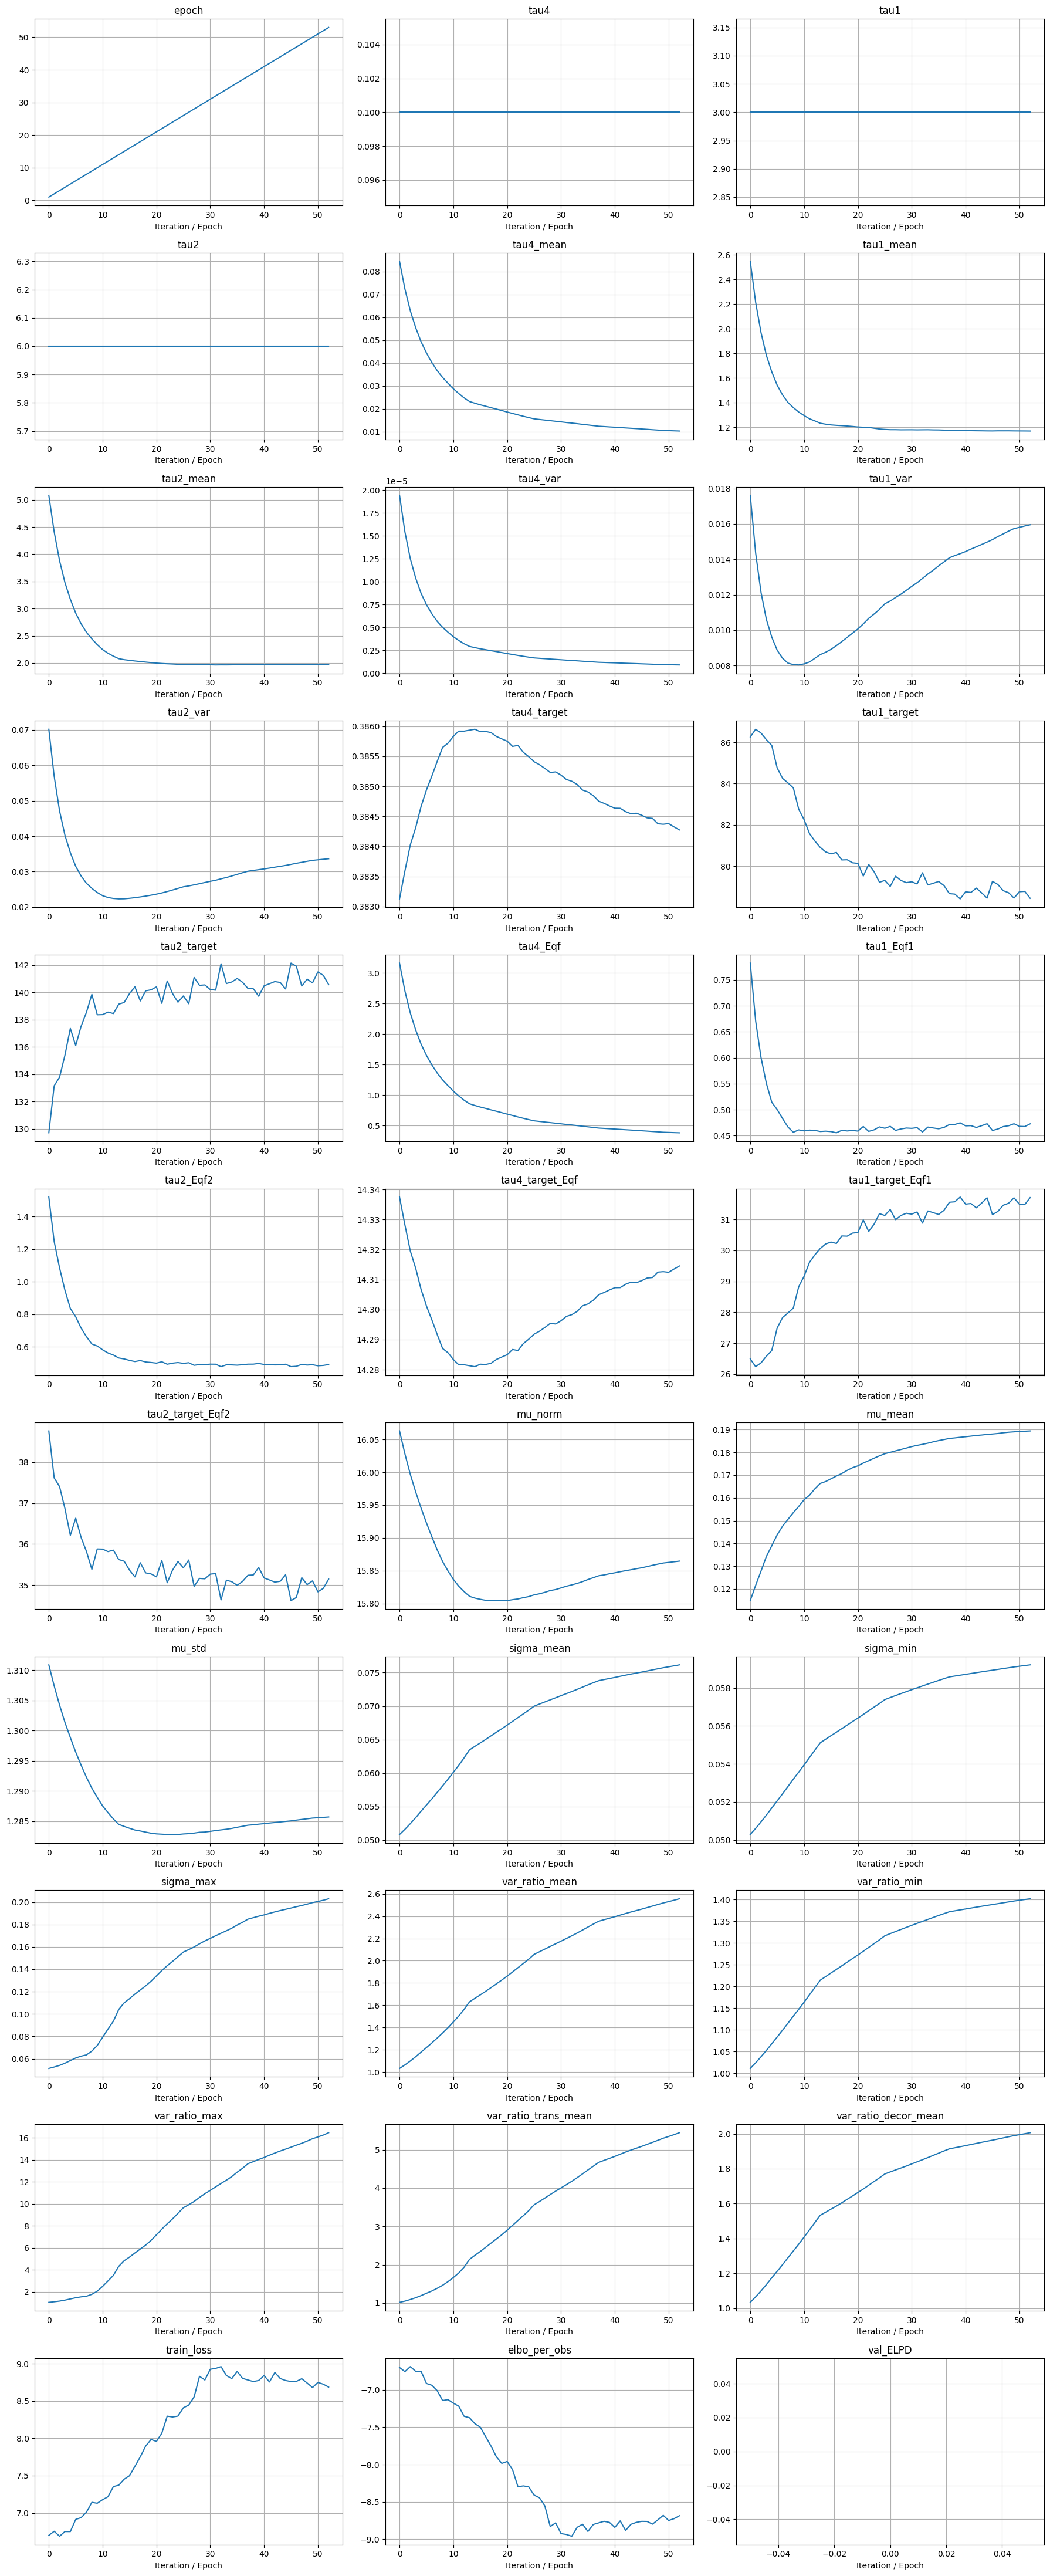

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



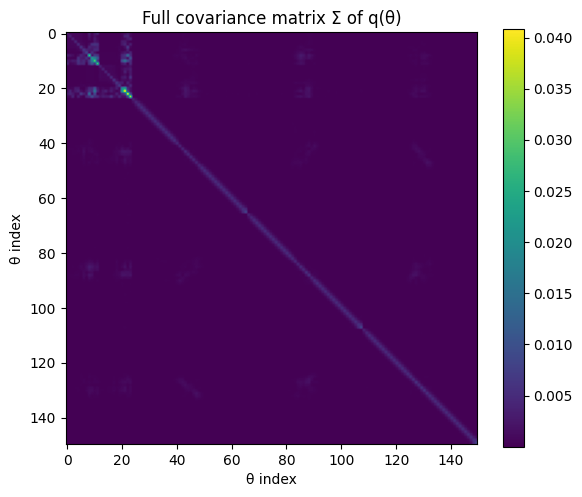

In [13]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


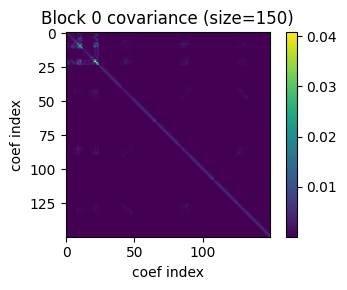

In [14]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [17]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0379
KLD GTM      Train Data:  0.0066
KLD Gaussian Train Data:  0.0985
KLD Copula   Train Data:  -0.0005

KLD BGTM      Test  Data:  0.049
KLD GTM      Test  Data:  0.0173
KLD Gaussian Test  Data:  0.1121
KLD Copula   Test  Data:  0.0018


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


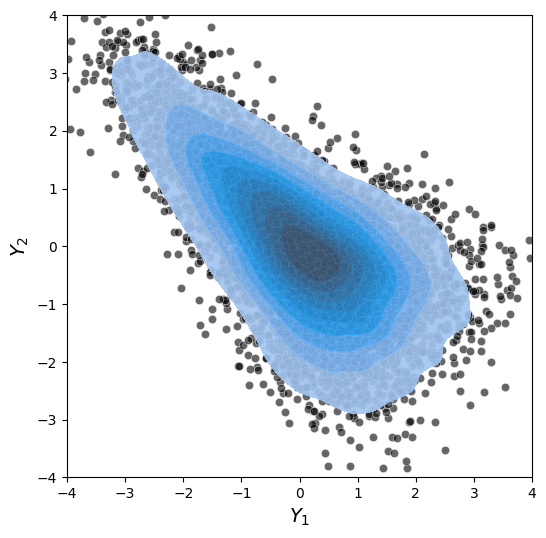

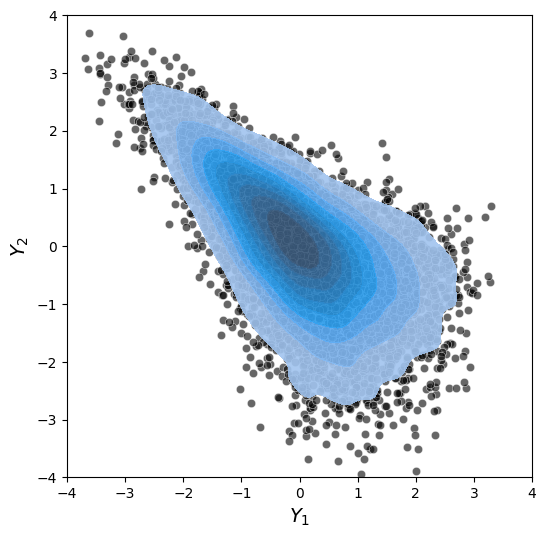

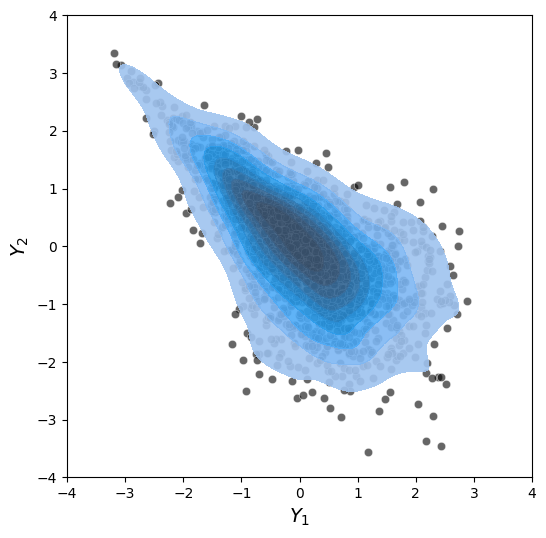

In [19]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


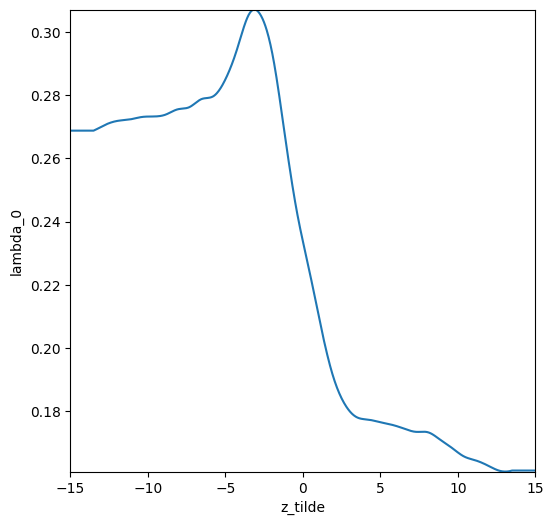

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


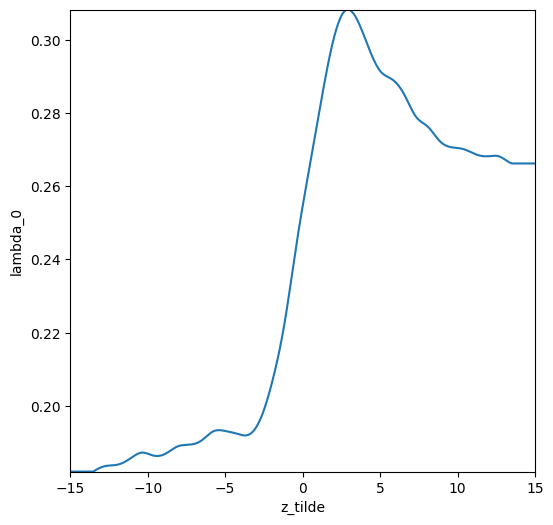

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


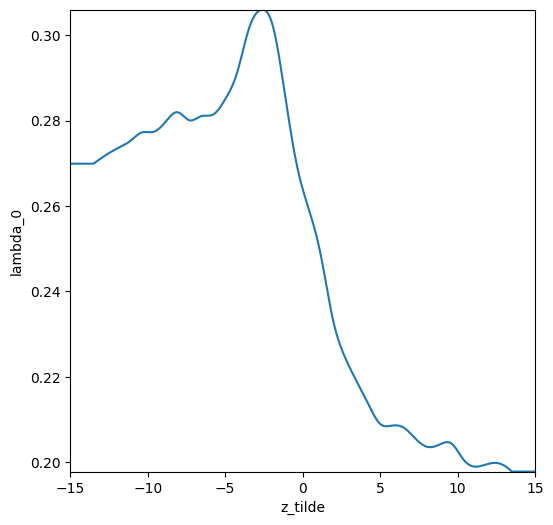

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)